# Higher Order Sensitivity Indices

<h4> By Nicholas Wong </h4>

In [1]:
import sys
sys.path.append('../') 

In [2]:
%matplotlib inline
from equadratures import *
import numpy as np
import scipy.stats as s

Variance indices (Sobol' indices) give the spread of the data away from the mean, but does not account for the direction of the spread and the relative weight of the tail of the distribution (the "peakiness"). In optimization, we may be interested in the extrema attained by the output, which concerns the tail of the output distribution.

Higher order sensitivity indices address precisely this concern. Higher order statistics, namely skewness and kurtosis, can be decomposed in a similar fashion to Sobol' indices, giving rise to conditional skewness and kurtosis indices. Individual components to the skewness and kurtosis with respect to each input variable or groups of such may be computed using methods in the Statistics class. 

<h2> Methodology </h2>

The computation of Sobol' indices is intuitive when conidering the computation of the global variance using polynomial chaos (PC), where we approximate a function $g(s)$ with a surrogate polynomial function $f(s)$, defined as

$$ f(s) = \sum_{i=1}^{P} x_i \phi_i(s). $$

Due to orthogonality of the basis polynomials, the global variance is computed as:

$$ \textrm{Var}[f(s)] = \sum_{i=1}^{P} x_i^2. $$

A Sobol' index simply sums up the squares of cofficients corresponding to contributing polynomials (i.e. polynomials with a non-zero order in the variables concerned. Conditional skewness/kurtosis indices follow the same principle.

Skewness and kurtosis are defined as the third and fourth central standardized moment. For instance, the skewness is:

$$\mu^{3} = \int_S (f(s) - \mu)^{3} \rho ds = \int_S \left(\sum_{i=1}^P x_i \phi_i(s)\right)^{3} \rho ds,$$

where $\rho$ is the input PDF, defined over $S$, the support. In practice, Gauss quadrature or Monte Carlo is used to evaluate the integral numerically, and two approaches can be taken. Firstly, one can sum the polynomial evaluations, each weighted by the corresponding coefficient, at the quadrature points, resulting in a "total evaluation" at each quadrature point. Then, cube/fourth the results and compute the integral by forming the inner product with a quadrature weight vector. (effectively sum-before-integral) This approach is $O(Pd)$ where $P$ is the number of basis terms and $d$ is the input dimension. This is satisfactory for computing the global skewness/kurtosis.

However, to compute conditional indices, it is necessary to expand the inner sum using the multinomial theorem first, as only by doing so will the result be interpretable as a sum of contributions from each  (group of) basis term(s) (effectively integral-before-sum). The details of such expansion is given in Geraci et al [1]. With computing the variance-based Sobol' indices, the cross term conveniently cancels with orthogonality. However, with skewness and kurtosis the cross terms do not necessarily cancel. This necessitates an $O(P^3d)$ operation for skewness and $O(P^4d)$ operation for kurtosis, resulting in forbiddingly long computational times. 

However, all is not lost, and some saving may be achieved with low order conditional skewness/kurtosis terms. Firstly, Geraci et al.[1] details some conditions where the integral in the sum need not be computed as they are zero. Secondly, as only cross term integrals that result in the variables we are interested in need to be computed, some basis terms can be eliminated a priori. For instance, when computing first order indices, it is not necessary to consider any basis term that has total order larger than 1, since any integral with such a basis term will only increase the number of participating variables, and certainly will not contribute to the first order index at the end. This reduces the complexity to $O(n^3d)$ for skewness, for example, where $n << P$ is the highest order of the polynomial in any dimension.

# <h2> Usage Example </h2>

Let's see the methods in action. We will use the piston problem from Kenett et al. [2]. Please refer to the notebook on Sobol' indices for further information. 

In [3]:
def piston(x):
    mass, area, volume, spring, pressure, ambtemp, gastemp = x[0], x[1], x[2], x[3], x[4], x[5], x[6]
    A = pressure * area + 19.62*mass - (spring * volume)/(1.0 * area)
    V = (area/(2*spring)) * ( np.sqrt(A**2 + 4*spring * pressure * volume * ambtemp/gastemp) - A)
    C = 2 * np.pi * np.sqrt(mass/(spring + area**2 * pressure * volume * ambtemp/(gastemp * V**2)))
    return C

Here we will use an order 5 polynomial in each of the seven dimensions and assume a uniform PDF in each dimension.

In [4]:
p_order = 5

mass = Parameter(distribution="Uniform", order = p_order, lower=30, upper=60)
area = Parameter(distribution="Uniform",order = p_order, lower=0.005, upper=0.020)
volume = Parameter(distribution="Uniform",order = p_order, lower=0.002, upper=0.010)
spring = Parameter(distribution="Uniform",order = p_order, lower=1000, upper=5000)
pressure = Parameter(distribution="Uniform",order = p_order, lower=90000, upper=110000)
ambtemp = Parameter(distribution="Uniform",order = p_order, lower=290, upper=296)
gastemp = Parameter(distribution="Uniform",order = p_order, lower=340, upper=360)
parameters = [mass, area, volume, spring, pressure, ambtemp, gastemp]

Let's use a degree 5 total order grid as the index set:

In [5]:
orders = [p_order,p_order,p_order,p_order,p_order,p_order,p_order]
polybasis = Basis("Total order", orders)

We have $^{12} C _5 = 792$ basis terms in our PC expansion. Let's use 3000 randomly sampled points to evaluate the PC coefficients (taking care to sample from the correct range) and initiate Statistics class:

In [6]:
sampled_points = np.random.uniform(size = (3000,7))

sampled_points = sampled_points * [30, .015, .008, 4000, 20000, 6, 20]
sampled_points = sampled_points + [30, .005, .002, 1000, 90000, 290, 340]

poly = Polyreg(parameters, polybasis, sampled_points, fun=piston)
coeffs_reg = poly.coefficients

stats = poly.getStatistics()

//anaconda/lib/python2.7/site-packages/equadratures-6.0-py2.7.egg/equadratures/polyreg.py:60: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  alpha = np.linalg.lstsq(self.A, self.bz) # Opted for numpy's standard version because of speed!


By default, global indices (mean, variance, skewness and kurtosis) are already computed at initialization. They can be viewed through printing the corresponding class variables

In [7]:
print stats.mean
print stats.variance
print stats.skewness
print stats.kurtosis

0.462431267368
0.0194609238842
0.612230346950315
3.3173232832787547


Now sample the output distribution with Monte Carlo and compute the statistics:

In [8]:
MC_samples = np.random.uniform(size = (100000,7))
MC_samples = MC_samples * [30, .015, .008, 4000, 20000, 6, 20]
MC_samples = MC_samples + [30, .005, .002, 1000, 90000, 290, 340]

f = np.zeros(100000)

for i in range(100000):
    f[i] = piston(MC_samples[i,:])

print np.mean(f)
print np.var(f)
print float(s.skew(f))
print float(s.kurtosis(f, fisher = False))

0.46143862991093704
0.01945817988243864
0.623864183398
3.33502121988


As seen, the agreement is not bad. Now, let's calculate the first two orders of conditional indices.

In [9]:
v1 = stats.getSobol(1)
v2 = stats.getSobol(2)
s1 = stats.getCondSkewness(1)
s2 = stats.getCondSkewness(2)
k1 = stats.getCondKurtosis(1)
k2 = stats.getCondKurtosis(2)

Here, the keys of each dict signify the dimensions involved in the index. Let's examine the sum of the indices in these two orders:

In [10]:
print sum(v1.values()) + sum(v2.values())
print sum(s1.values()) + sum(s2.values())
print sum(k1.values()) + sum(k2.values())

0.989842644295
0.7661779241968563
0.7424654065124542


As seen, the sums are close to one, so we don't miss much by not evaluating the rest of the indices (which could take a long time). We visualize the first-order Sobol', skewness and kurtosis indices by plotting a bar chart.

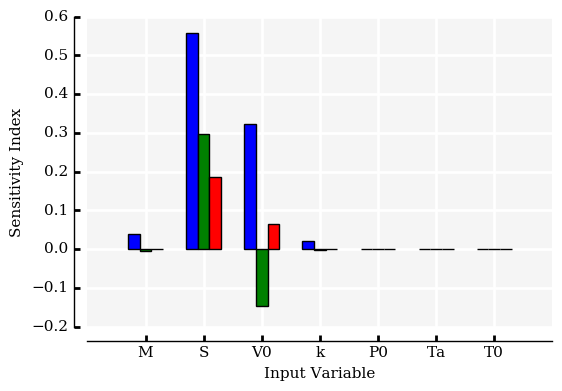

In [11]:
vp = []
sp = []
kp = []
for i in [(0,),(1,),(2,),(3,),(4,),(5,),(6,)]:
    vp.append(v1[i])
    sp.append(s1[i])
    kp.append(k1[i])
fig, ax = plt.subplots()
x = np.arange(7)
ax.bar(x-0.2, vp,width=0.2,color='b',align='center')
ax.bar(x, sp,width=0.2,color='g',align='center')
ax.bar(x+0.2, kp,width=0.2,color='r',align='center')
plt.xticks(x, ('M', 'S', 'V0', 'k', 'P0', 'Ta', 'T0'))
adjust_spines(ax, ['left', 'bottom'])
plt.xlabel('Input Variable')
plt.ylabel('Sensitivity Index')
plt.show()

From the plot above, not only do we conclude that $S$ and $V_0$, corresponding to the piston area and gas volume respectively, are the most important to the output, but also the fact that $S$ contributes strongly to positive skewness and $V_0$ to negative skewness.

<h4>References</h4>

[1]: Geraci, G., Congedo, P. M., Abgrall, R., & Iaccarino, G. (2016). High-order statistics in global sensitivity analysis: decomposition and model reduction. Computer Methods in Applied Mechanics and Engineering, 301, 80-115.

[2]: Kenett, Ron, Shelemyahu Zacks, and Daniele Amberti. Modern Industrial Statistics: with applications in R, MINITAB and JMP. John Wiley & Sons, 2013.